# Pollock Modeling: Feature Extraction, Training, and Spatial Prediction

This notebook is the second stage of the Alaska Pollock geospatial analysis workflow.  
It builds on the composite image prepared in the `Pollock_Composition` notebook and focuses on:

- Extracting features over spatial units (e.g., fishing zones, polygons)
- Preparing training and validation datasets
- Fitting machine learning models to predict fishing effort or catch
- Mapping model predictions across the study area

The primary data source is the `final_composite` image previously exported to Earth Engine:

`projects/ee-batistahpedro/assets/Pollock/final_composite_2012`




In [1]:
!pip install earthengine-api
!pip install geemap
!apt-get install -y python3-cartopy python3-pip
!pip install geopandas matplotlib
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-lyx libimagequant0 liblbfgsb0 libraqm0 libxsimd-dev
  python-cartopy-data python-matplotlib-data python3-appdirs python3-attr
  python3-beniget python3-brotli python3-bs4 python3-certifi python3-chardet
  python3-cycler python3-dateutil python3-decorator python3-fonttools
  python3-fs python3-gast python3-html5lib python3-kiwisolver python3-lxml
  python3-lz4 python3-matplotlib python3-mpmath python3-numpy python3-olefile
  python3-packaging python3-pil python3-pil.imagetk python3-ply python3-pyproj
  python3-pyshp python3-pythran python3-scipy python3-setuptools
  python3-shapely python3-soupsieve python3-sympy python3-tz python3-ufolib2
  python3-unicodedata2 python3-webencodings python3-wheel unicode-data
Suggested packages:
  libxsim

## ⚙️ Step 1: Authenticate Earth Engine and Mount Google Drive

Authenticate with Earth Engine and mount your Google Drive to access spatial data and save outputs.

The Earth Engine project ID used here should match the one used in the composite generation notebook.


In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-batistahpedro')

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 🗺️ Step 2: Load Pollock Shapefile and Final Composite

In this step, we load two essential inputs for the modeling workflow:

1. A shapefile containing spatially disaggregated data on Alaska Pollock from the year 2012.
2. The `final_composite` image assembled in the previous notebook and stored as a Google Earth Engine asset.

The shapefile includes:
- Gear type
- Catch volume and rate
- Biomass and effort levels
- Polygon geometries for spatial aggregation

The composite image includes a multiband stack of satellite and environmental variables, and will be used to extract zonal statistics for model training and evaluation.

### Data Sources

- 📁 **Shapefile repository**:  
  https://github.com/batistahpedro/Pollock_ML/tree/main/Shapefiles

- 🌐 **Earth Engine Asset**:  
  `projects/ee-batistahpedro/assets/Pollock/final_composite_2012`

📂 Ensure that:
- The shapefile and its associated files (`.shp`, `.shx`, `.dbf`, `.prj`, etc.) are stored together in your Google Drive or accessed via a `.zip` from GitHub.
- The Earth Engine asset path is updated if you're working from a different account.




In [3]:
import geopandas as gpd
import ee

# Load shapefile
shapefile_path = "/content/drive/MyDrive/Pollock/Shapefiles/Pollock_2012.shp"
gdf = gpd.read_file(shapefile_path)

# Ensure EPSG:4326 for Earth Engine compatibility
if gdf.crs is None or gdf.crs.to_epsg() != 4326:
    gdf = gdf.set_crs(epsg=4326) if gdf.crs is None else gdf.to_crs(epsg=4326)

# Load final composite from Earth Engine
final_composite = ee.Image("projects/ee-batistahpedro/assets/Pollock/final_composite_2012")

# Confirm loading
print(f"✅ Shapefile loaded with {len(gdf)} features (CRS: {gdf.crs}).")
print("✅ Final composite loaded:", isinstance(final_composite, ee.Image))





✅ Shapefile loaded with 1125 features (CRS: EPSG:4326).
✅ Final composite loaded: True


Columns and data types:
gear_type       object
year             int64
catch_tons     float64
catch_rate     float64
species_na      object
species_co       int64
biomass_to     float64
effort         float64
polygon_id       int32
geometry      geometry
dtype: object

Basic summary statistics:


year    catch_tons   catch_rate  species_co   biomass_to  \
count  1125.0  1.125000e+03  1125.000000      1125.0  1125.000000   
mean   2012.0  1.049738e+06    36.154554       201.0  1768.407736   
std       0.0  2.679981e+06    43.618751         0.0  1606.724058   
min    2012.0  1.250000e+00     0.000527       201.0     0.000000   
25%    2012.0  3.255510e+03     1.874007       201.0   373.693542   
50%    2012.0  2.431090e+04     7.552980       201.0  1572.806885   
75%    2012.0  8.159982e+05    96.434292       201.0  2631.556885   
max    2012.0  2.882434e+07    99.996999       201.0  8889.157227   

             effort   polygon_id  
count   1125.000000  1125.000000  
mean     555.480632   563.000000  
std     1327.799883   324.903832  
min        0.000000     1.000000  
25%       38.719505   282.000000  
50%      171.760956   563.000000  
75%      470.129364   844.000000  
max    13574.231445  1125.000000


Missing values by column:
gear_type     0
year          0
catch_tons    0
catch_rate    0
species_na    0
species_co    0
biomass_to    0
effort        0
polygon_id    0
geometry      0
dtype: int64


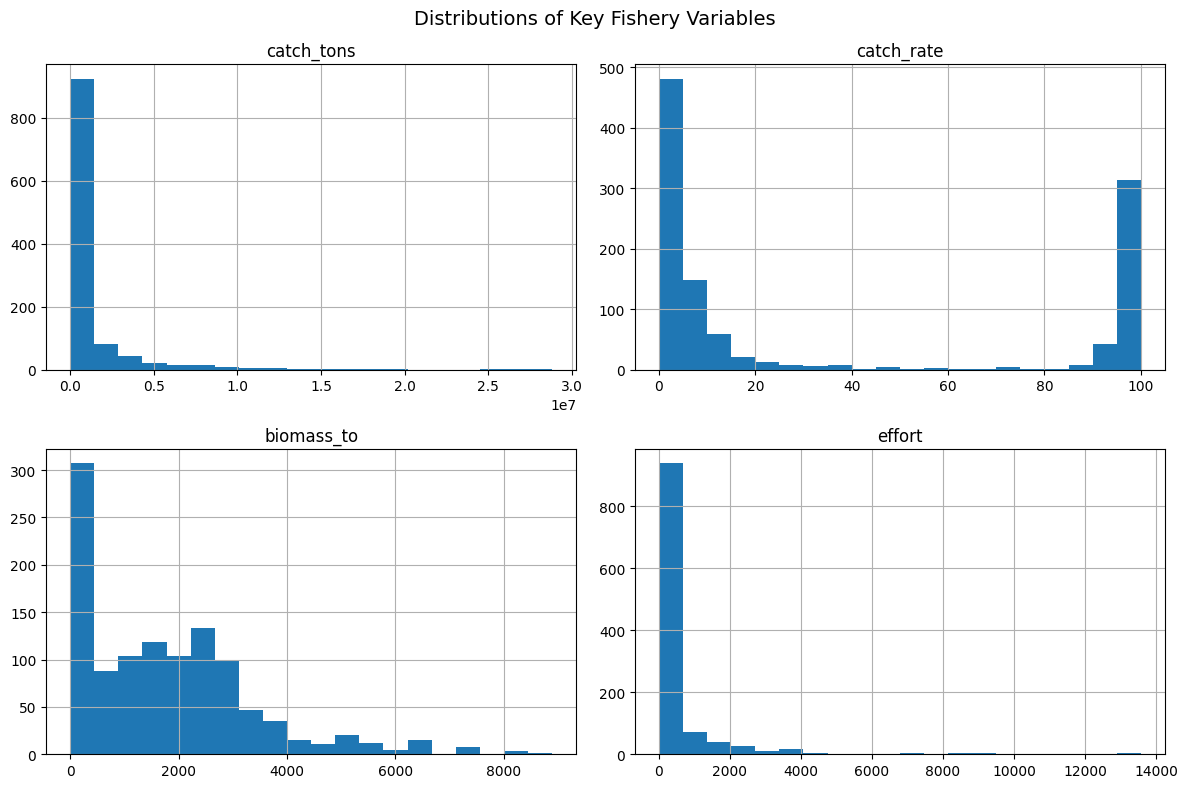

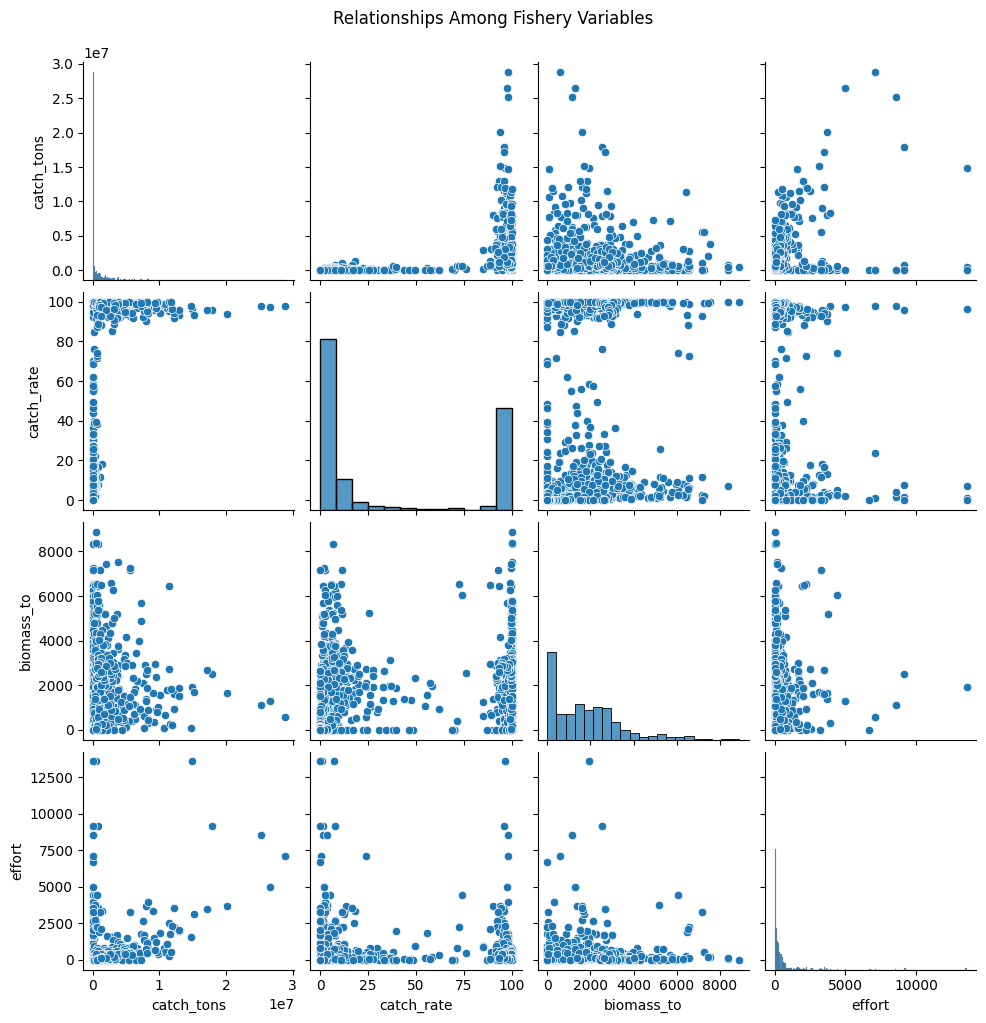

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic structure
print("Columns and data types:")
print(gdf.dtypes)
print("\nBasic summary statistics:")
display(gdf.describe())

# Check for missing values
print("\nMissing values by column:")
print(gdf.isna().sum())

# Plot distributions of key numeric variables
numeric_cols = ['catch_tons', 'catch_rate', 'biomass_to', 'effort']

# Plot histograms
gdf[numeric_cols].hist(bins=20, figsize=(12, 8), layout=(2, 2))
plt.suptitle("Distributions of Key Fishery Variables", fontsize=14)
plt.tight_layout()
plt.show()

# Pairplot to examine relationships (optional for small datasets)
sns.pairplot(gdf[numeric_cols])
plt.suptitle("Relationships Among Fishery Variables", y=1.02)
plt.show()


## Step 3: Feature Extraction and Exploratory Analysis

In this step, we extract satellite-derived features from the `final_composite` image at the centroid of each polygon in the spatial dataset.

These values are then organized into a modeling-ready dataset, which is explored using basic statistical and visual tools.

The analysis includes:

- Sampling composite bands at polygon centroids
- Generating a feature table for modeling
- Checking for missing values and distributions
- Exploring correlations between features and the target variable (`biomass_tons`)


In [5]:
import geopandas as gpd
import pandas as pd
import ee

# 1. Compute centroids
gdf["centroid"] = gdf.geometry.centroid

# 2. Convert centroids to an Earth Engine FeatureCollection
features = []
for idx, row in gdf.iterrows():
    centroid = row["centroid"]
    ee_point = ee.Geometry.Point([centroid.x, centroid.y])
    feature = ee.Feature(ee_point, {
        "polygon_id": row["polygon_id"],
        "biomass_to": row["biomass_to"]
    })
    features.append(feature)

ee_fc = ee.FeatureCollection(features)

# 3. Sample the final composite at the centroid locations
results = final_composite.sampleRegions(
    collection=ee_fc,
    scale=10,
    geometries=True
).getInfo()

# 4. Convert results to a DataFrame
df_list = []
for feature in results["features"]:
    props = feature["properties"]
    coords = feature["geometry"]["coordinates"]
    props["x_proj"] = coords[0]
    props["y_proj"] = coords[1]
    df_list.append(props)

df = pd.DataFrame(df_list)

# 5. Reorder columns
column_order = ["polygon_id", "biomass_to"] + [col for col in df.columns if col not in ["polygon_id", "biomass_to"]]
df = df[column_order]

# 6. Save results to CSV
output_path = "/content/drive/MyDrive/Pollock/Profiles/Pollock_Spectral_Profiles_3832.csv"
df.to_csv(output_path, index=False)

print(f"Feature extraction completed. Results saved to: {output_path}")


<ipython-input-5-27c66ca496ec>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid


Feature extraction completed. Results saved to: /content/drive/MyDrive/Pollock/Profiles/Pollock_Spectral_Profiles_3832.csv


Dataset shape: (1059, 92)

Missing values:
polygon_id                   0
biomass_to                   0
Bathymetry                   0
MODIS_Aqua_Rrs_412_max       0
MODIS_Aqua_Rrs_412_median    0
                            ..
sur_refl_b16_max             0
sur_refl_b16_median          0
sur_refl_b16_min             0
x_proj                       0
y_proj                       0
Length: 92, dtype: int64


polygon_id   biomass_to   Bathymetry  MODIS_Aqua_Rrs_412_max  \
count  1059.000000  1059.000000  1059.000000             1059.000000   
mean    557.527856  1856.766487  -297.175387                0.009537   
std     326.065414  1605.337147   554.396993                0.001577   
min       2.000000     0.000000 -3811.008065                0.006285   
25%     273.500000   479.978073  -253.847898                0.008302   
50%     550.000000  1647.954468   -92.357843                0.009329   
75%     839.500000  2685.691650   -58.758135                0.010609   
max    1125.000000  8889.157227   395.710257                0.015658   

       MODIS_Aqua_Rrs_412_median  MODIS_Aqua_Rrs_412_min  \
count                1059.000000             1059.000000   
mean                    0.003662                0.000289   
std                     0.000535                0.001110   
min                     0.002501               -0.003961   
25%                     0.003241               -0.000646   
50%                     0.003570                0.000128   
75%                     0.004066                0.001244   
max                     0.005013                0.002653   

       MODIS_Aqua_Rrs_443_max  MODIS_Aqua_Rrs_443_median  \
count             1059.000000                1059.000000   
mean                 0.007748                   0.003460   
std                  0.001347                   0.000470   
min                  0.005365                   0.002553   
25%                  0.006669                   0.003145   
50%                  0.007667                   0.003379   
75%                  0.008627                   0.003768   
max                  0.013473                   0.004757   

       MODIS_Aqua_Rrs_443_min  MODIS_Aqua_Rrs_469_max  ...  \
count             1059.000000             1059.000000  ...   
mean                 0.000855                0.006993  ...   
std                  0.000773                0.001300  ...   
min                 -0.000540                0.004934  ...   
25%                  0.000177                0.005956  ...   
50%                  0.000683                0.006832  ...   
75%                  0.001544                0.007736  ...   
max                  0.002622                0.013835  ...   

       sur_refl_b14_median  sur_refl_b14_min  sur_refl_b15_max  \
count          1059.000000      1.059000e+03       1059.000000   
mean              0.000135     -1.000000e-02          0.296503   
std               0.003245      1.721840e-16          0.090889   
min              -0.009814     -1.000000e-02          0.087555   
25%              -0.002161     -1.000000e-02          0.224904   
50%               0.000457     -1.000000e-02          0.292212   
75%               0.001993     -1.000000e-02          0.364301   
max               0.008776     -1.000000e-02          0.530401   

       sur_refl_b15_median  sur_refl_b15_min  sur_refl_b16_max  \
count          1059.000000      1.059000e+03       1059.000000   
mean             -0.003811     -1.000000e-02          0.382357   
std               0.002421      1.721840e-16          0.092927   
min              -0.009899     -1.000000e-02          0.118343   
25%              -0.005382     -1.000000e-02          0.311999   
50%              -0.004025     -1.000000e-02          0.396781   
75%              -0.002409     -1.000000e-02          0.442068   
max               0.003860     -1.000000e-02          0.586470   

       sur_refl_b16_median  sur_refl_b16_min       x_proj       y_proj  
count          1059.000000      1.059000e+03  1059.000000  1059.000000  
mean              0.000968     -1.000000e-02  -166.828603    57.180424  
std               0.002722      1.721840e-16    24.455697     1.798404  
min              -0.009804     -1.000000e-02  -179.833332    51.367599  
25%              -0.001030     -1.000000e-02  -173.166665    56.110524  
50%               0.000933     -1.000000e-02  -168.166642    57.165147  
75%              

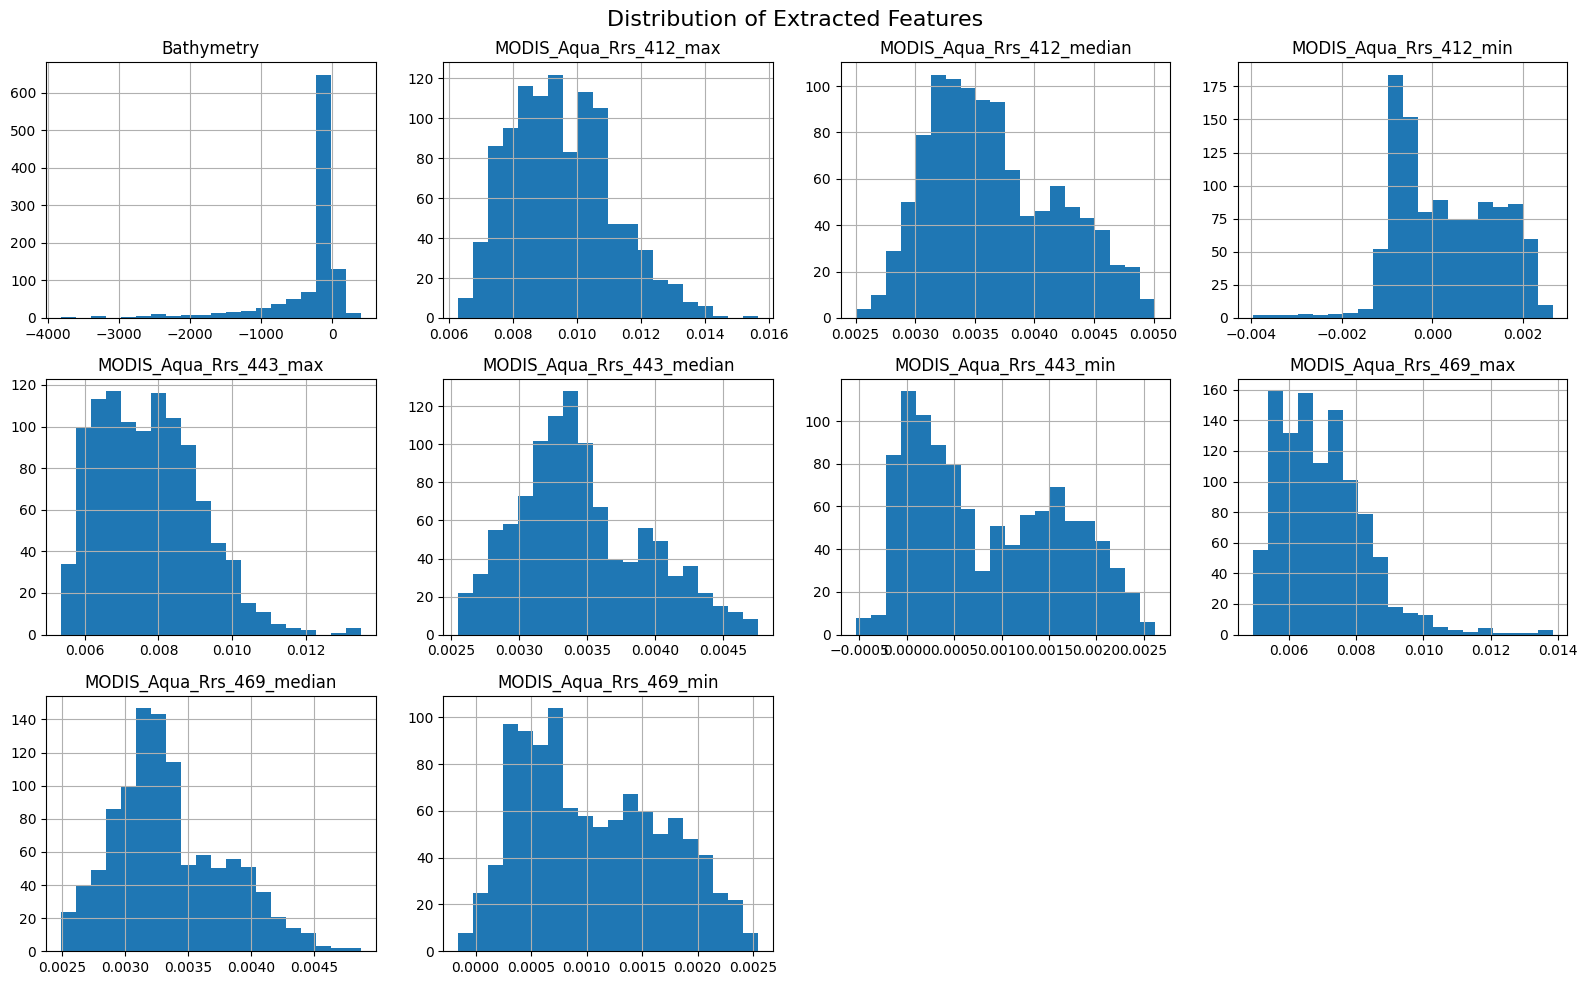

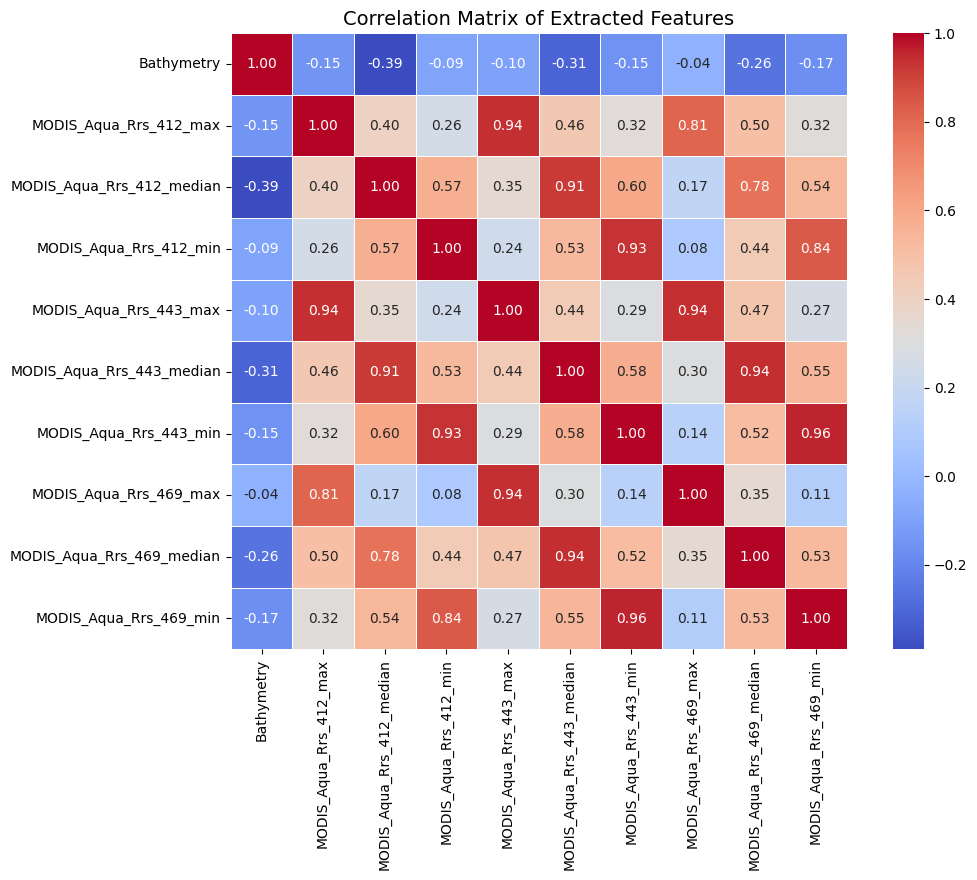

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary and structure
print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

display(df.describe())

# Distribution plots
selected_features = df.columns[2:12]  # Adjust if needed
df[selected_features].hist(bins=20, figsize=(16, 10), layout=(3, 4))
plt.suptitle("Distribution of Extracted Features", fontsize=16)
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df[selected_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Extracted Features", fontsize=14)
plt.show()


## Step 4: Model Training, Evaluation, and Feature Importance

In this step, we train a Random Forest regression model to predict Pollock biomass (`biomass_to`) using satellite-derived features.

The full workflow includes:

- Preparing and cleaning the dataset
- Training the model using 80% of the data
- Evaluating model performance on the remaining 20%
- Computing standard metrics (R², RMSE, MAE, MAPE, MdAPE, F1 Score)
- Visualizing the relationship between predicted and actual biomass
- Plotting the top 15 most important features used by the model


Model Performance on Test Data:
R² Score: 0.8914
RMSE: 587.0655 (32.02% of mean biomass)
MAE: 302.9900 (16.52% of mean biomass)
MAPE: 105.41%
MdAPE: 9.44%
Overall Accuracy (100 - MdAPE): 90.56%
F1 Score (binary threshold on median): 0.9674


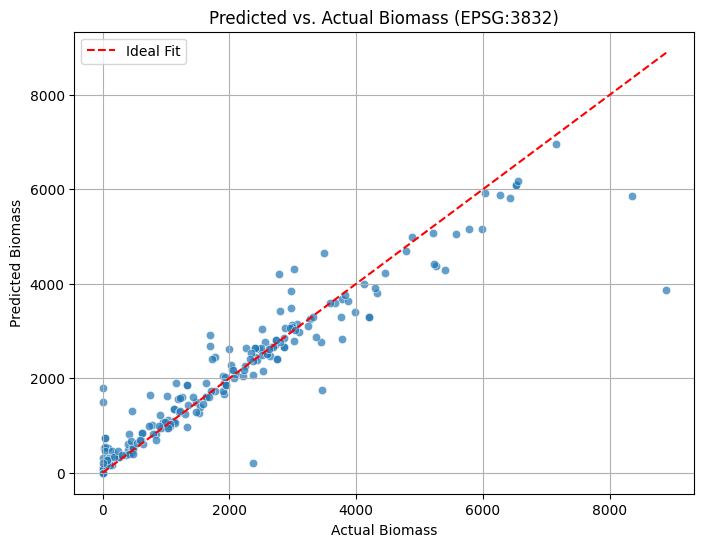

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split

# 1. Load dataset
csv_path = "/content/drive/My Drive/Pollock/Profiles/Pollock_Spectral_Profiles_3832.csv"
df = pd.read_csv(csv_path)

# 2. Remove non-predictive or spatial columns
drop_columns = ['polygon_id', 'x_proj', 'y_proj']
df.drop(columns=[col for col in drop_columns if col in df.columns], inplace=True)

# 3. Drop rows with missing values
df.dropna(inplace=True)

# 4. Define features (X) and target (y)
X = df.drop(columns=["biomass_to"])
y = df["biomass_to"]

# 5. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 7. Predict on test set
y_pred = model.predict(X_test)

# 8. Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

epsilon = 1e-10
non_zero_mask = y_test > epsilon
mape = np.mean(np.abs((y_test[non_zero_mask] - y_pred[non_zero_mask]) / (y_test[non_zero_mask] + epsilon))) * 100
mdape = np.median(np.abs((y_test[non_zero_mask] - y_pred[non_zero_mask]) / (y_test[non_zero_mask] + epsilon))) * 100
overall_accuracy = 100 - mdape

threshold = y_train.median()
y_test_bin = (y_test > threshold).astype(int)
y_pred_bin = (y_pred > threshold).astype(int)
f1 = f1_score(y_test_bin, y_pred_bin)

# 9. Display results
print("Model Performance on Test Data:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f} ({rmse / y_train.mean():.2%} of mean biomass)")
print(f"MAE: {mae:.4f} ({mae / y_train.mean():.2%} of mean biomass)")
print(f"MAPE: {mape:.2f}%")
print(f"MdAPE: {mdape:.2f}%")
print(f"Overall Accuracy (100 - MdAPE): {overall_accuracy:.2f}%")
print(f"F1 Score (binary threshold on median): {f1:.4f}")

# 10. Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label="Ideal Fit")
plt.xlabel("Actual Biomass")
plt.ylabel("Predicted Biomass")
plt.title("Predicted vs. Actual Biomass (EPSG:3832)")
plt.legend()
plt.grid(True)
plt.show()


Feature Importance Analysis

<ipython-input-8-cccadb159b37>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


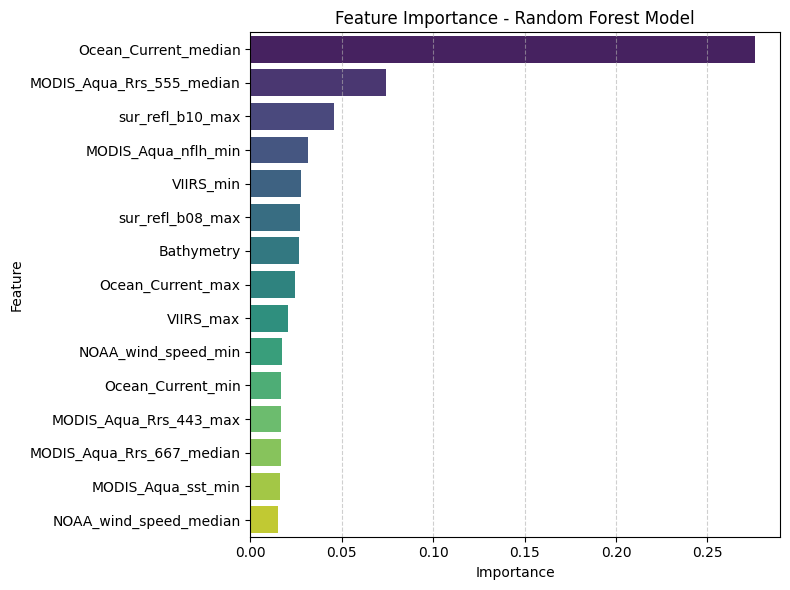

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

# Load trained model (optional if already in memory)
model_path = "/content/drive/My Drive/Pollock/Models/Pollock_Biomass_Model.pkl"
model = joblib.load(model_path)

# Ensure X is defined
if 'X' not in globals():
    raise ValueError("Feature matrix X must be defined before loading feature importances.")

# Extract feature importances
feature_importance = model.feature_importances_
feature_names = X.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

# Sort and select top 15
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(15)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest Model")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Step 5: Spatial Prediction Mapping via Grid Sampling

In this step, we generate a uniform spatial grid across the study area and apply the trained Random Forest model to predict Pollock biomass for each cell.

This process includes:

- Generating a grid of rectangles (based on average polygon size from the training shapefile)
- Extracting the centroids of each grid cell
- Sampling the composite image at each centroid
- Predicting biomass using the trained model
- Saving the results in batches to avoid memory and API limits

The output consists of a series of CSV files (one per batch) with biomass predictions and associated coordinates, which can be later combined and mapped.


Grid Sampling and Spatial Prediction

In [11]:
import ee
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib
import time
import os

# 1. Load shapefile to estimate grid resolution
shapefile_path = "/content/drive/My Drive/Pollock/Shapefiles/Pollock_2012.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Ensure CRS is EPSG:4326 (required for Earth Engine geometry operations and grid size in degrees)
if gdf.crs is None or gdf.crs.to_epsg() != 4326:
    print("Reprojecting to EPSG:4326 for compatibility with Earth Engine...")
    gdf = gdf.set_crs(epsg=4326) if gdf.crs is None else gdf.to_crs(epsg=4326)

# 3. Estimate average grid size (in degrees)
gdf["width"] = gdf.bounds.maxx - gdf.bounds.minx
gdf["height"] = gdf.bounds.maxy - gdf.bounds.miny
grid_size_degrees = (gdf["width"].mean() + gdf["height"].mean()) / 2
print(f"Estimated grid size: {grid_size_degrees:.4f} degrees")

# 4. Define AOI
aoi = ee.Geometry.Polygon([
    [[150, 45], [150, 70], [-150, 70], [-150, 45], [150, 45]]
])

# 5. Generate grid
def create_grid(aoi, grid_size):
    bounds = aoi.bounds().getInfo()["coordinates"][0]
    min_lon, min_lat = bounds[0]
    max_lon, max_lat = bounds[2]
    lon_points = np.arange(min_lon, max_lon, grid_size)
    lat_points = np.arange(min_lat, max_lat, grid_size)

    grid = [ee.Feature(ee.Geometry.Rectangle([lon, lat, lon + grid_size, lat + grid_size]))
            for lon in lon_points for lat in lat_points]
    total_cells = len(grid)
    print(f"Total grid cells: {total_cells}")
    return ee.FeatureCollection(grid), total_cells

full_grid, estimated_grid_cells = create_grid(aoi, grid_size_degrees)

# 6. Extract centroids
centroids_fc = full_grid.map(lambda f: f.centroid().set({}))
centroid_list = centroids_fc.toList(estimated_grid_cells)

# 7. Setup batch processing
batch_size = 100
num_batches = int(np.ceil(estimated_grid_cells / batch_size))
output_dir = "/content/drive/My Drive/Pollock/Batches/"
os.makedirs(output_dir, exist_ok=True)

# 8. Load trained model
model_path = "/content/drive/My Drive/Pollock/Models/Pollock_Biomass_Model.pkl"
model = joblib.load(model_path)

# 9. Check for already processed batches
existing_batches = {
    int(f.split("_")[-1].split(".")[0])
    for f in os.listdir(output_dir)
    if f.startswith("Pollock_Biomass_batch_") and f.endswith(".csv")
}
print(f"{len(existing_batches)} previously saved batches found.")

# 10. Process remaining batches
for i in range(num_batches):
    batch_num = i + 1
    if batch_num in existing_batches:
        print(f"Skipping already processed batch {batch_num:04}")
        continue

    print(f"Processing batch {batch_num}/{num_batches}...")
    offset = i * batch_size
    batch = centroid_list.slice(offset, offset + batch_size)
    batch_fc = ee.FeatureCollection(batch)

    final_composite_4326 = final_composite.reproject(crs="EPSG:4326", scale=1000)

    try:
        results = final_composite_4326.sampleRegions(
            collection=batch_fc,
            scale=1000,
            geometries=True
        ).getInfo()
    except Exception as e:
        print(f"Error in batch {batch_num}: {e}")
        continue

    # Assemble DataFrame
    batch_data = []
    for feature in results.get("features", []):
        props = feature["properties"]
        coords = feature["geometry"]["coordinates"]
        props["longitude"] = coords[0]
        props["latitude"] = coords[1]
        batch_data.append(props)

    df = pd.DataFrame(batch_data)

    # Predict biomass
    if not df.empty:
        X = df.drop(columns=["longitude", "latitude"], errors="ignore")
        df["predicted_biomass"] = model.predict(X)

    # Save batch results
    batch_filename = f"Pollock_Biomass_batch_{batch_num:04}.csv"
    batch_path = os.path.join(output_dir, batch_filename)
    df.to_csv(batch_path, index=False)
    print(f"Saved batch {batch_num} to {batch_path}")

    time.sleep(2)  # Avoid hitting Earth Engine API limits

print("All batches processed successfully.")


Estimated grid size: 0.2978 degrees
Total grid cells: 18786
0 previously saved batches found.
Processing batch 1/188...
Saved batch 1 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0001.csv
Processing batch 2/188...
Saved batch 2 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0002.csv
Processing batch 3/188...
Saved batch 3 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0003.csv
Processing batch 4/188...
Saved batch 4 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0004.csv
Processing batch 5/188...
Saved batch 5 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0005.csv
Processing batch 6/188...
Saved batch 6 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0006.csv
Processing batch 7/188...
Saved batch 7 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0007.csv
Processing batch 8/188...
Saved batch 8 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_000

Saved batch 62 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0062.csv
Processing batch 63/188...
Saved batch 63 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0063.csv
Processing batch 64/188...
Saved batch 64 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0064.csv
Processing batch 65/188...
Saved batch 65 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0065.csv
Processing batch 66/188...
Saved batch 66 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0066.csv
Processing batch 67/188...
Saved batch 67 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0067.csv
Processing batch 68/188...
Saved batch 68 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0068.csv
Processing batch 69/188...
Saved batch 69 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0069.csv
Processing batch 70/188...


Saved batch 70 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0070.csv
Processing batch 71/188...
Saved batch 71 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0071.csv
Processing batch 72/188...
Saved batch 72 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0072.csv
Processing batch 73/188...
Saved batch 73 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0073.csv
Processing batch 74/188...
Saved batch 74 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0074.csv
Processing batch 75/188...
Saved batch 75 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0075.csv
Processing batch 76/188...
Saved batch 76 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0076.csv
Processing batch 77/188...
Saved batch 77 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomass_batch_0077.csv
Processing batch 78/188...
Saved batch 78 to /content/drive/My Drive/Pollock/Batches/Pollock_Biomas

In [34]:
import os
from glob import glob

# Directory containing batch results
batch_dir = "/content/drive/My Drive/Pollock/Batches/"
output_path = "/content/drive/My Drive/Pollock/Predicted_Biomass.csv"

# List all batch CSVs
csv_files = sorted(glob(os.path.join(batch_dir, "Pollock_Biomass_batch_*.csv")))
print(f"Total batch files found: {len(csv_files)}")

# Merge CSVs into one (keeping header from the first file and skipping empty files)
with open(output_path, 'w') as outfile:
    for i, file in enumerate(csv_files):
        # Check if the file is empty
        if os.stat(file).st_size == 0:
            print(f"Skipping empty file: {file}")
            continue  # Skip empty files

        with open(file, 'r') as infile:
            lines = infile.readlines()
            if not lines:
                continue  # Skip empty files

            if i == 0:
                outfile.writelines(lines)  # Write header for the first file
            else:
                outfile.writelines(lines[1:])  # Skip header for subsequent files

print(f"\n✅ Merged file saved to: {output_path}")


Total batch files found: 188

✅ Merged file saved to: /content/drive/My Drive/Pollock/Predicted_Biomass.csv


In [37]:
import os
from glob import glob
import pandas as pd

# Directory containing batch results
batch_dir = "/content/drive/My Drive/Pollock/Batches/"
output_path = "/content/drive/My Drive/Pollock/Predicted_Biomass.csv"

# List all batch CSVs
csv_files = sorted(glob(os.path.join(batch_dir, "Pollock_Biomass_batch_*.csv")))
print(f"Total batch files found: {len(csv_files)}")

# Initialize a flag to track when we find the first valid file
first_file_found = False

# Loop through all files and process them
for file in csv_files:
    # Check if the file is empty
    if os.stat(file).st_size == 0:
        print(f"Skipping empty file: {file}")
        continue  # Skip empty files

    # Read the file
    df = pd.read_csv(file)

    if not df.empty:  # Only process files with data
        if not first_file_found:
            # First valid file: write to output CSV (including header)
            df.to_csv(output_path, index=False)
            first_file_found = True
            print(f"Processing first file with valid data: {file}")
        else:
            # Subsequent files: append data without header
            df.to_csv(output_path, mode='a', header=False, index=False)
            print(f"Appending data from file: {file}")

print(f"\n✅ Merged file saved to: {output_path}")


Total batch files found: 188


EmptyDataError: No columns to parse from file

In [41]:
import os
from glob import glob
import csv

# 📂 Directory of the CSV files
batch_dir = "/content/drive/My Drive/Pollock/Batches/"
output_path = "/content/drive/My Drive/Pollock/Predicted_Biomass.csv"

# 📦 List all batch files
csv_files = sorted(glob(os.path.join(batch_dir, "Pollock_Biomass_batch_*.csv")))
print(f"🔍 Total files found: {len(csv_files)}")

header = None
data_rows = []
header_found = False

# 🔍 Find the first file with a header and collect all data
for file in csv_files:
    with open(file, 'r', newline='') as infile:
        reader = csv.reader(infile)
        try:
            first_row = next(reader)
            if not header_found and first_row:
                header = first_row
                header_found = True
            elif header and first_row != header:
                data_rows.append(first_row)
            elif not header and first_row:
                data_rows.append(first_row) # Add the first row as data if no header has been found yet
            for row in reader:
                data_rows.append(row)
        except StopIteration:
            print(f"⚠️ Empty file found: {file}")
            continue # Skip to the next file

# ✅ Write the header (if found) and all data to the output file
with open(output_path, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    if header:
        writer.writerow(header)
        writer.writerows(data_rows)
        print(f"\n✅ Successfully generated the single file at: {output_path} with the first header found.")
    else:
        writer.writerows(data_rows)
        print(f"\n✅ Successfully generated the single file at: {output_path} (no valid header found).")

🔍 Total files found: 188

✅ Successfully generated the single file at: /content/drive/My Drive/Pollock/Predicted_Biomass.csv with the first header found.


## Step 7: Mapping Predicted Biomass

To visualize the spatial distribution of predicted Pollock biomass, we adopt two complementary mapping approaches:

1. **Static Map (Matplotlib):**  
   A clean, publication-ready map where each cell is rendered as a fixed-size square, colored by its predicted biomass value. This visualization is useful for reports, figures, and reproducible snapshots of model outputs.

2. **Interactive Map (Folium):**  
   An interactive HTML-based map where each grid cell is rendered as a clickable rectangle. Users can zoom, pan, and visually explore biomass patterns across the Bering Sea.

Both approaches use a consistent color scale and align with the same spatial grid used during sampling and modeling.

### 🌍 International Date Line Correction

Because the study area spans the western Pacific, some longitudes in the grid exceed 180° (e.g., 185°). In geographic coordinate systems like EPSG:4326, longitudes must fall within -180° to +180°. Values above +180° would "wrap around" to the opposite side of the world, causing visual breaks in maps.

To solve this, we **shift longitudes greater than 150° (East)** to their corresponding negative value. This adjustment ensures that grid cells in the **Bering Sea region** align correctly and remain continuous. For example:
- **175°E** is kept as **175°**,
- **185°E** is shifted to **-175°**.

Both the static and interactive maps use this corrected longitude (`longitude_corr`) to avoid distortions caused by the International Date Line.

> The final output includes an HTML map (for sharing and exploration) and a static figure (for reporting and publications).



In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 1. Load prediction results
csv_path = "/content/drive/My Drive/Pollock/Predicted_Biomass.csv"
df = pd.read_csv(csv_path)

# 2. Load original shapefile and ensure it is in EPSG:4326
gdf = gpd.read_file("/content/drive/My Drive/Pollock/Shapefiles/Pollock_2012.shp")

if gdf.crs is None or gdf.crs.to_epsg() != 4326:
    print("Reprojecting shapefile to EPSG:4326...")
    gdf = gdf.set_crs(epsg=4326) if gdf.crs is None else gdf.to_crs(epsg=4326)

# 3. Estimate grid size from average polygon dimensions (in degrees)
gdf["width"] = gdf.bounds.maxx - gdf.bounds.minx
gdf["height"] = gdf.bounds.maxy - gdf.bounds.miny
grid_size_deg = (gdf["width"].mean() + gdf["height"].mean()) / 2
print(f"Estimated grid size: {grid_size_deg:.4f} degrees")

# 4. Correct longitudes > 150° (IDL correction)
df["longitude_corr"] = df["longitude"].apply(lambda lon: lon - 360 if lon > 150 else lon)

# 5. Set up color normalization
norm = Normalize(vmin=df["predicted_biomass"].min(), vmax=df["predicted_biomass"].max())
cmap = plt.colormaps.get_cmap("viridis")

# 6. Create plot
fig, ax = plt.subplots(figsize=(16, 10))

# 7. Plot each cell as a rectangle
for _, row in df.iterrows():
    lon = row["longitude_corr"]
    lat = row["latitude"]
    biomass = row["predicted_biomass"]
    color = cmap(norm(biomass))

    rect = Rectangle(
        (lon - grid_size_deg / 2, lat - grid_size_deg / 2),
        grid_size_deg,
        grid_size_deg,
        linewidth=0,
        edgecolor=None,
        facecolor=color
    )
    ax.add_patch(rect)

# 8. Adjust plot extent
ax.set_xlim(df["longitude_corr"].min() - grid_size_deg, df["longitude_corr"].max() + grid_size_deg)
ax.set_ylim(df["latitude"].min() - grid_size_deg, df["latitude"].max() + grid_size_deg)

# 9. Add colorbar and labels
sm = ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(sm, ax=ax, label="Predicted Biomass")
ax.set_title("Predicted Biomass (Corrected for International Date Line)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("auto")

plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import geopandas as gpd
import folium
import branca.colormap as cm
import numpy as np

# 1. Load prediction results
csv_path = "/content/drive/My Drive/Pollock/Predicted_Biomass.csv"
df = pd.read_csv(csv_path)

# 2. Estimate grid size from shapefile
shapefile_path = "/content/drive/My Drive/Pollock/Shapefiles/Pollock_2012.shp"
gdf = gpd.read_file(shapefile_path)

# Ensure correct projection
if gdf.crs is None or gdf.crs.to_epsg() != 4326:
    gdf = gdf.set_crs(epsg=4326) if gdf.crs is None else gdf.to_crs(epsg=4326)

gdf["width"] = gdf.bounds.maxx - gdf.bounds.minx
gdf["height"] = gdf.bounds.maxy - gdf.bounds.miny
grid_size_deg = (gdf["width"].mean() + gdf["height"].mean()) / 2
print(f"Estimated grid size (from shapefile): {grid_size_deg:.4f} degrees")

# 3. Correct longitudes for IDL
df["longitude_corr"] = df["longitude"].apply(lambda lon: lon - 360 if lon > 150 else lon)

# 4. Create colormap
min_bio, max_bio = df["predicted_biomass"].min(), df["predicted_biomass"].max()
colormap = cm.LinearColormap(colors=["blue", "green", "yellow", "red"], vmin=min_bio, vmax=max_bio)

# 5. Initialize map
m = folium.Map(location=[58, -175], zoom_start=4, tiles="cartodbpositron")

# 6. Plot grid cells
for _, row in df.iterrows():
    lon = row["longitude_corr"]
    lat = row["latitude"]
    color = colormap(row["predicted_biomass"])
    bounds = [
        [lat - grid_size_deg / 2, lon - grid_size_deg / 2],
        [lat + grid_size_deg / 2, lon + grid_size_deg / 2]
    ]
    folium.Rectangle(
        bounds=bounds,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        weight=0
    ).add_to(m)

# 7. Add colorbar
colormap.caption = "Predicted Biomass"
colormap.add_to(m)

# 8. Save map
map_path = "/content/drive/My Drive/Pollock/Predicted_Biomass_Folium.html"
m.save(map_path)
print(f"✅ Interactive map saved at: {map_path}")

# 9. Display in notebook
m


Estimated grid size (from shapefile): 0.2978 degrees
✅ Interactive map saved at: /content/drive/My Drive/Pollock/Predicted_Biomass_Folium.html
